In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn import preprocessing
import random
import seaborn as sns
import skbio.diversity.alpha as alpha
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression


/Users/Diana_Gong/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/Diana_Gong/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/Diana_Gong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Importing OTU table, normalization (change to relative abundances), set training and testing groups

In [2]:
# Import data into a pandas dataframe
otu_table = pd.read_csv('EGAD00001003453.otu_table.99.denovo', sep='\t', header=0, index_col=0)

#Transpose OTU table so that samples are rows and OTUs are columns
otu_table = otu_table.T

#Convert to relative abundances
#Normalize each person to 1 (change to relative abundances)
otu_table_normalized = otu_table.div(otu_table.sum(axis=1), axis=0)

In [3]:
#Make training and testing sets (50/50 for now)

#Scramble existing table with hard-coded random seed
otu_table_normalized = otu_table_normalized.sample(frac=1, random_state=1)

#Make first half training and second half testing
total_people = otu_table_normalized.shape[0]
print(total_people)
midway = total_people/2
training_table = otu_table_normalized.iloc[0:int(midway)]
testing_table = otu_table_normalized.iloc[int(midway):]


1010


### Set conditions to test:

In [4]:
N = [5, 10, 25, 40, 50, 60, 75, 100, 200]
weight_setup = ['even', 'uneven_100x', 'uneven_10x', 'uneven_graduated']#, 'uneven_bins']
num_bins = 3

#Number of times to run each condition (N and weight setup)
num_repeats = 30

### Functions

Returns list of weights to multiply by relative abundance matrix according to parameters n and weight

In [5]:
def calculate_weights(n,weight):
    if weight == 'even':
        return [1/n]*n
    elif weight == 'uneven_100x':
        x = 1/(100 + (n-1))
        return [100*x] + [x]*(n-1)
    elif weight == 'uneven_10x':
        x = 1/(10 + (n-1))
        return [10*x] + [x]*(n-1)
    elif weight == 'uneven_graduated':
        decreasing_list = list(range(n,0,-1))
        return [x/sum(decreasing_list) for x in decreasing_list]    

### Master loop: Generate all samples for given conditions

In [6]:
df_list = []
#Generate matrix of random seeds of size num_repeats x len(N), which is how many random numbers are needed for this sampling experiment
random_seed = np.random.randint(0, high=30000, size=(num_repeats,len(N)))

for i in range(num_repeats):
    for j, n in enumerate(N):
        #Generate random sample of size n using generated random seed
        random_sample = training_table.sample(n=n, random_state = random_seed[i][j], replace=True)
        
        for m, weight in enumerate(weight_setup):
            #Set up actual weights
            weight_list = calculate_weights(n,weight)
            
            #Calculate weighted OTU table
            for k in range(n):
                random_sample.iloc[k] = random_sample.iloc[k]*weight_list[k]
                
            #Calculate weighted mean
            indiv_series = random_sample.mean(axis=0)
            
            #Store data + info/metadata as new pandas Series
            sample_name = str(n) + "_" + weight + "_" + str(i)
            sample_number = i*len(N)*len(weight_setup) + j*len(weight_setup) + m
            indiv_series.loc['sample_name'] = sample_name
            indiv_series.loc['N'] = n
            indiv_series.loc['weight_setup'] = weight
            indiv_series.loc['weight_vector'] = weight_list
            indiv_series.loc['random_seed'] = random_seed[i][j]
            
            #Turn Series into a one-line DataFrame
            indiv_df = pd.DataFrame(indiv_series, columns=[str(sample_number)])
            #Add to list of all generated DataFrames with metadata
            df_list.append(indiv_df)
            
#Concatenate list of dataframes into a single dataframe
final_matrix = pd.concat(df_list, axis=1)
print(final_matrix.tail())

                                       0  \
OTU_ID                                     
sample_name                     5_even_0   
N                                      5   
weight_setup                        even   
weight_vector  [0.2, 0.2, 0.2, 0.2, 0.2]   
random_seed                        15684   

                                                               1  \
OTU_ID                                                             
sample_name                                      5_uneven_100x_0   
N                                                              5   
weight_setup                                         uneven_100x   
weight_vector  [0.9615384615384616, 0.009615384615384616, 0.0...   
random_seed                                                15684   

                                                               2  \
OTU_ID                                                             
sample_name                                       5_uneven_10x_0   
N         

In [7]:
#Transpose matrix so that samples are rows and OTUs and metadata are columns
final_matrix = final_matrix.T

In [8]:
#Save final_matrix to a csv file
final_matrix.to_csv('final_matrix.csv')

In [9]:
final_matrix

OTU_ID,denovo7709,denovo5395,denovo11322,denovo44859,denovo44858,denovo41472,denovo41473,denovo41470,denovo41471,denovo41476,...,denovo22219,denovo22218,denovo43272,denovo32739,denovo32738,sample_name,N,weight_setup,weight_vector,random_seed
0,0,1.14882e-05,0,0,0,0,0,0,0,0,...,0,0,0,0,1.03149e-06,5_even_0,5,even,"[0.2, 0.2, 0.2, 0.2, 0.2]",15684
1,0,1.10463e-07,0,0,0,0,0,0,0,0,...,0,0,0,0,9.91814e-07,5_uneven_100x_0,5,uneven_100x,"[0.9615384615384616, 0.009615384615384616, 0.0...",15684
2,0,7.89025e-09,0,0,0,0,0,0,0,0,...,0,0,0,0,7.08438e-07,5_uneven_10x_0,5,uneven_10x,"[0.7142857142857142, 0.07142857142857142, 0.07...",15684
3,0,5.26017e-10,0,0,0,0,0,0,0,0,...,0,0,0,0,2.36146e-07,5_uneven_graduated_0,5,uneven_graduated,"[0.3333333333333333, 0.26666666666666666, 0.2,...",15684
4,0,1.15937e-07,0,1.15937e-07,0,0,0,0,2.36278e-07,0,...,2.29814e-07,0,0,0,0,10_even_0,10,even,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",27249
5,0,1.06364e-09,0,1.06364e-09,0,0,0,0,2.16769e-09,0,...,2.10838e-09,0,0,0,0,10_uneven_100x_0,10,uneven_100x,"[0.9174311926605505, 0.009174311926605505, 0.0...",27249
6,0,5.5981e-11,0,5.5981e-11,0,0,0,0,1.14089e-10,0,...,1.10968e-10,0,0,0,0,10_uneven_10x_0,10,uneven_10x,"[0.5263157894736842, 0.05263157894736842, 0.05...",27249
7,0,6.10702e-12,0,6.10702e-12,0,0,0,0,1.86691e-11,0,...,3.65011e-12,0,0,0,0,10_uneven_graduated_0,10,uneven_graduated,"[0.18181818181818182, 0.16363636363636364, 0.1...",27249
8,9.68997e-08,1.01087e-07,0,1.85499e-08,0,0,0,0,1.37397e-08,1.23482e-08,...,0,0,0,0,0,25_even_0,25,even,"[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...",16839
9,7.81449e-10,8.15216e-10,0,1.49596e-10,0,0,0,0,1.10804e-10,9.95819e-11,...,0,0,0,0,0,25_uneven_100x_0,25,uneven_100x,"[0.8064516129032258, 0.008064516129032258, 0.0...",16839


### Look at various metrics from samples

#### Number of OTUs detected per sample

In [10]:
final_matrix['n_otus'] = final_matrix[:final_matrix.shape[0]-5].astype(bool).sum(axis=1).astype(int)

In [11]:
final_matrix_rel = final_matrix.iloc[:,:-6]
final_matrix_otus_only = final_matrix.iloc[:,:-6]*10000000
final_matrix_otus_only = final_matrix_otus_only.astype(int)

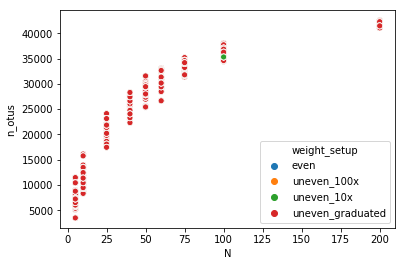

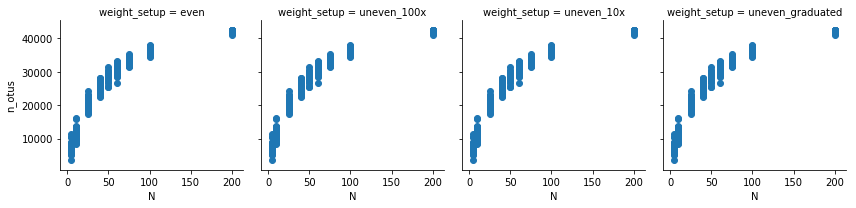

In [12]:
sns.scatterplot(x='N',y='n_otus',hue='weight_setup',data=final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=final_matrix)
g.map(plt.scatter, 'N', 'n_otus')
plt.show()

#### Alpha diversity: chao1

In [13]:
final_matrix['chao1'] = [alpha.chao1(list(row),bias_corrected=True) for index, row in final_matrix_otus_only.iterrows()]

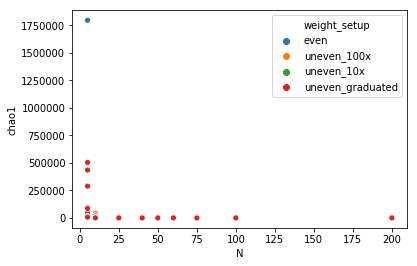

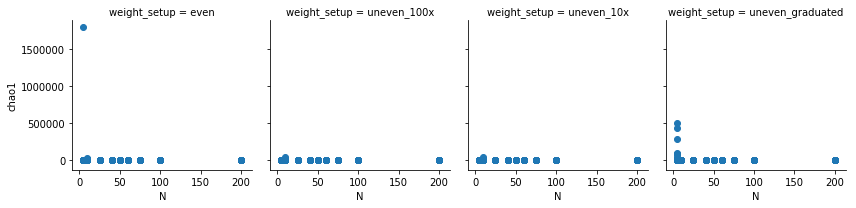

In [14]:
sns.scatterplot(x='N',y='chao1',hue='weight_setup',data=final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=final_matrix)
g.map(plt.scatter, 'N', 'chao1')
plt.show()

#### Alpha diversity: fisher_alpha

In [15]:
final_matrix['fisheralpha'] = [alpha.fisher_alpha(list(row)) for index, row in final_matrix_otus_only.iterrows()]

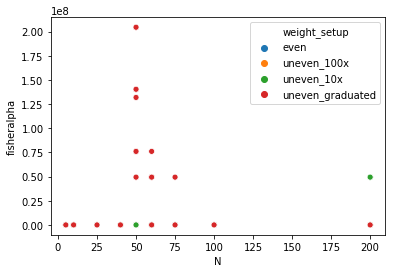

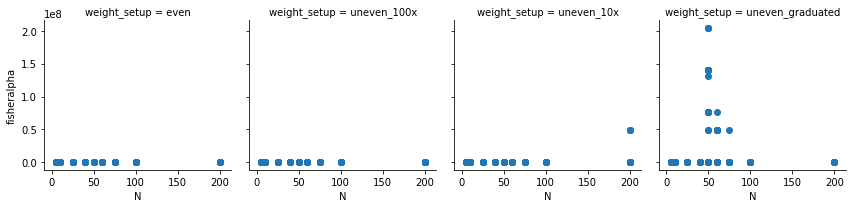

In [16]:
sns.scatterplot(x='N',y='fisheralpha',hue='weight_setup',data=final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=final_matrix)
g.map(plt.scatter, 'N', 'fisheralpha')
plt.show()

#### Alpha diversity: shannon

Approach 1: Add 1 to every value in count matrix (converted from rel abundance matrix) and use skbio function

In [17]:
final_matrix['shannon_pseudocount'] = [alpha.shannon(list(row + 1),base=2) for index, row in final_matrix_otus_only.iterrows()]

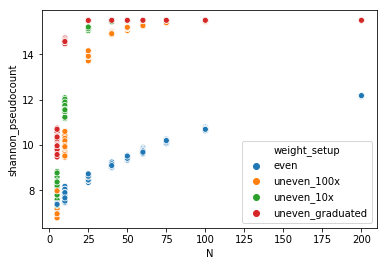

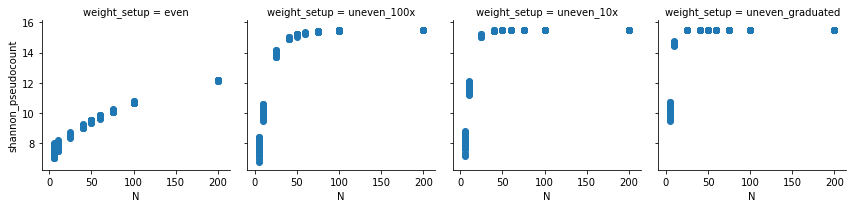

In [18]:
sns.scatterplot(x='N',y='shannon_pseudocount',hue='weight_setup',data=final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=final_matrix)
g.map(plt.scatter, 'N', 'shannon_pseudocount')
plt.show()

Approach 2: Add minimum value in relative abundance matrix to each value in matrix, calculate shannon using skbio function

In [19]:
#final_matrix['shannon'] = [alpha.shannon(list(row),base=2) for index, row in final_matrix_otus_only.iterrows()]

min_value = final_matrix_rel[final_matrix_rel > 0].min().min()
print(min_value)
final_matrix_rel_add = final_matrix_rel + min_value
final_matrix['shannon'] = [alpha.shannon(list(row),base=2) for index, row in final_matrix_rel_add.iterrows()]


1.2188444121322345e-19


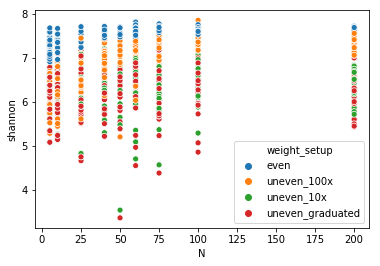

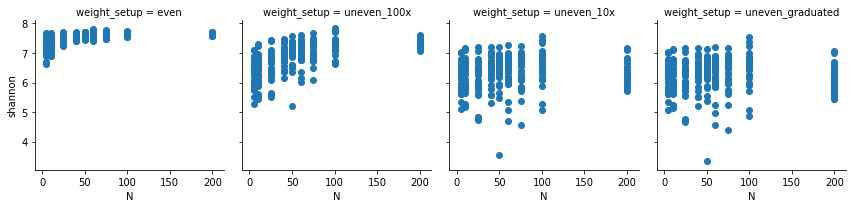

In [20]:
sns.scatterplot(x='N',y='shannon',hue='weight_setup',data=final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=final_matrix)
g.map(plt.scatter, 'N', 'shannon')
plt.show()

Approach 3: Add minimum value in relative abundance matrix to each value in matrix, calculate shannon by hand

In [21]:
final_matrix_shannon = final_matrix_rel_add.applymap(lambda x: x*math.log2(x))

In [22]:
final_matrix['shannon_by_hand'] = [-row.sum() for index, row in final_matrix_shannon.iterrows()]

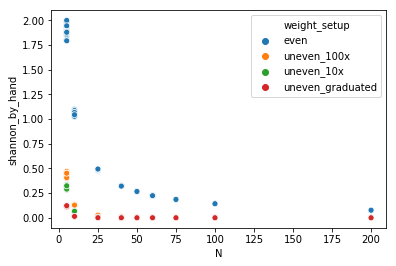

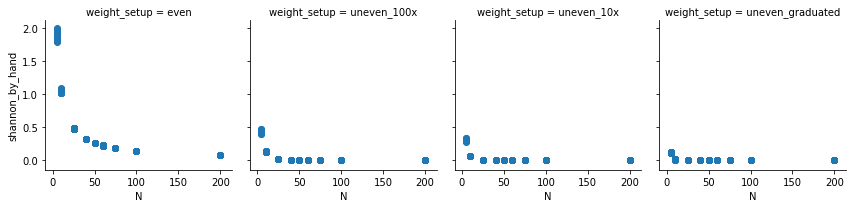

In [23]:
sns.scatterplot(x='N',y='shannon_by_hand',hue='weight_setup',data=final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=final_matrix)
g.map(plt.scatter, 'N', 'shannon_by_hand')
plt.show()

Approach 4: Take rel abundance matrix without adding minimum value, calculate shannon by hand

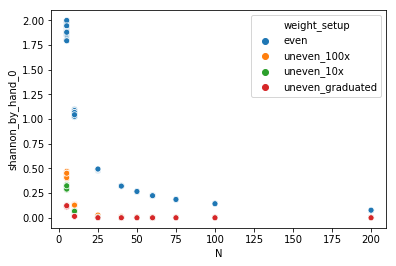

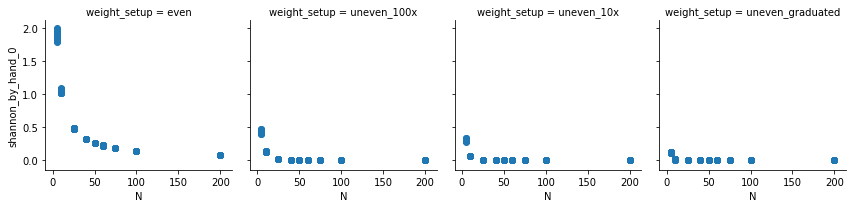

In [24]:
final_matrix_shannon = final_matrix_rel.applymap(lambda x: x*math.log2(x) if x!=0 else 0)
final_matrix['shannon_by_hand_0'] = [-row.sum() for index, row in final_matrix_shannon.iterrows()]

sns.scatterplot(x='N',y='shannon_by_hand_0',hue='weight_setup',data=final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=final_matrix)
g.map(plt.scatter, 'N', 'shannon_by_hand_0')
plt.show()

In [25]:
final_matrix

OTU_ID,denovo7709,denovo5395,denovo11322,denovo44859,denovo44858,denovo41472,denovo41473,denovo41470,denovo41471,denovo41476,...,weight_setup,weight_vector,random_seed,n_otus,chao1,fisheralpha,shannon_pseudocount,shannon,shannon_by_hand,shannon_by_hand_0
0,0,1.14882e-05,0,0,0,0,0,0,0,0,...,even,"[0.2, 0.2, 0.2, 0.2, 0.2]",15684,6151.0,6146.000000,7.835633e+02,7.290194,6.969836,1.858353e+00,1.858353e+00
1,0,1.10463e-07,0,0,0,0,0,0,0,0,...,uneven_100x,"[0.9615384615384616, 0.009615384615384616, 0.0...",15684,6151.0,2066.000000,2.752393e+02,8.395655,7.097779,4.696654e-01,4.696654e-01
2,0,7.89025e-09,0,0,0,0,0,0,0,0,...,uneven_10x,"[0.7142857142857142, 0.07142857142857142, 0.07...",15684,6151.0,1871.500000,2.698867e+02,8.830961,7.049556,3.373237e-01,3.373237e-01
3,0,5.26017e-10,0,0,0,0,0,0,0,0,...,uneven_graduated,"[0.3333333333333333, 0.26666666666666666, 0.2,...",15684,6151.0,1860.000000,3.309935e+02,10.746713,7.045465,1.267494e-01,1.267494e-01
4,0,1.15937e-07,0,1.15937e-07,0,0,0,0,2.36278e-07,0,...,even,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",27249,12029.0,15967.308511,1.707712e+03,7.953515,7.428811,1.075074e+00,1.075074e+00
5,0,1.06364e-09,0,1.06364e-09,0,0,0,0,2.16769e-09,0,...,uneven_100x,"[0.9174311926605505, 0.009174311926605505, 0.0...",27249,12029.0,8735.049180,3.361294e+02,9.817541,6.024827,1.266868e-01,1.266868e-01
6,0,5.5981e-11,0,5.5981e-11,0,0,0,0,1.14089e-10,0,...,uneven_10x,"[0.5263157894736842, 0.05263157894736842, 0.05...",27249,12029.0,1250.460432,1.507791e+02,11.426513,5.786880,6.561734e-02,6.561734e-02
7,0,6.10702e-12,0,6.10702e-12,0,0,0,0,1.86691e-11,0,...,uneven_graduated,"[0.18181818181818182, 0.16363636363636364, 0.1...",27249,12029.0,340.238095,5.225668e+01,14.545954,5.768571,1.403567e-02,1.403567e-02
8,9.68997e-08,1.01087e-07,0,1.85499e-08,0,0,0,0,1.37397e-08,1.23482e-08,...,even,"[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...",16839,20133.0,9404.224049,9.864178e+02,8.488980,7.420659,4.825806e-01,4.825806e-01
9,7.81449e-10,8.15216e-10,0,1.49596e-10,0,0,0,0,1.10804e-10,9.95819e-11,...,uneven_100x,"[0.8064516129032258, 0.008064516129032258, 0.0...",16839,20133.0,857.300000,9.442483e+01,13.979308,6.683238,2.555352e-02,2.555352e-02


### Random forest regression

First, tried training only on samples with even distribution

In [26]:
#Training only on samples with even distribution
X = final_matrix[final_matrix['weight_setup'] == 'even']
X_nolabels = X.iloc[:,:-12]
y = X['N']

In [27]:
regr = RandomForestRegressor(random_state=0)

In [28]:
regr = regr.fit(X_nolabels,y)

#### Generate test matrix

In [29]:
df_list = []
#Generate matrix of random seeds of size num_repeats x len(N), which is how many random numbers are needed for this sampling experiment
random_seed = np.random.randint(0, high=30000, size=(num_repeats,len(N)))

for i in range(num_repeats):
    for j, n in enumerate(N):
        #Generate random sample of size n using generated random seed
        random_sample = testing_table.sample(n=n, random_state = random_seed[i][j], replace=True)
        
        for m, weight in enumerate(weight_setup):
            #Set up actual weights
            weight_list = calculate_weights(n,weight)
            
            #Calculate weighted OTU table
            for k in range(n):
                random_sample.iloc[k] = random_sample.iloc[k]*weight_list[k]
                
            #Calculate weighted mean
            indiv_series = random_sample.mean(axis=0)
            
            #Store data + info/metadata as new pandas Series
            sample_name = str(n) + "_" + weight + "_" + str(i)
            sample_number = i*len(N)*len(weight_setup) + j*len(weight_setup) + m
            indiv_series.loc['sample_name'] = sample_name
            indiv_series.loc['N'] = n
            indiv_series.loc['weight_setup'] = weight
            indiv_series.loc['weight_vector'] = weight_list
            indiv_series.loc['random_seed'] = random_seed[i][j]
            
            #Turn Series into a one-line DataFrame
            indiv_df = pd.DataFrame(indiv_series, columns=[str(sample_number)])
            #Add to list of all generated DataFrames with metadata
            df_list.append(indiv_df)
            
#Concatenate list of dataframes into a single dataframe
test_matrix = pd.concat(df_list, axis=1)

In [30]:
#Transpose matrix so that samples are rows and OTUs and metadata are columns
test_matrix = test_matrix.T

#Save final_matrix to a csv file
test_matrix.to_csv('test_matrix.csv')

In [31]:
prediction = regr.predict(test_matrix.iloc[:,:-5])

In [32]:
test_matrix['prediction'] = prediction

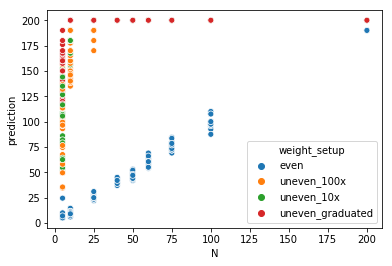

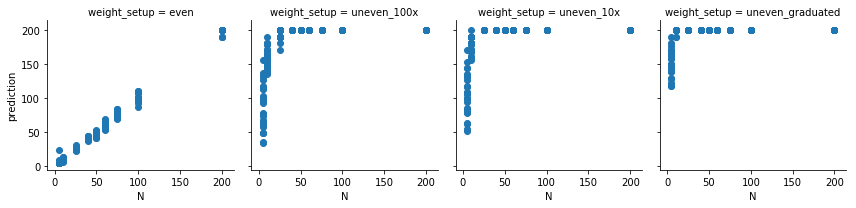

In [33]:
sns.scatterplot(x='N',y='prediction',hue='weight_setup', data=test_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=test_matrix)
g.map(plt.scatter, 'N', 'prediction')
plt.show()

In [34]:
test_matrix

OTU_ID,denovo7709,denovo5395,denovo11322,denovo44859,denovo44858,denovo41472,denovo41473,denovo41470,denovo41471,denovo41476,...,denovo22218,denovo43272,denovo32739,denovo32738,sample_name,N,weight_setup,weight_vector,random_seed,prediction
0,0,8.86309e-07,0,0,0,0,0,0,0,0,...,0,0,0,0,5_even_0,5,even,"[0.2, 0.2, 0.2, 0.2, 0.2]",12828,7.0
1,0,8.5222e-07,0,0,0,0,0,0,0,0,...,0,0,0,0,5_uneven_100x_0,5,uneven_100x,"[0.9615384615384616, 0.009615384615384616, 0.0...",12828,34.5
2,0,6.08729e-07,0,0,0,0,0,0,0,0,...,0,0,0,0,5_uneven_10x_0,5,uneven_10x,"[0.7142857142857142, 0.07142857142857142, 0.07...",12828,52.0
3,0,2.0291e-07,0,0,0,0,0,0,0,0,...,0,0,0,0,5_uneven_graduated_0,5,uneven_graduated,"[0.3333333333333333, 0.26666666666666666, 0.2,...",12828,140.0
4,0,2.21577e-07,0,0,0,0,0,0,0,0,...,0,0,0,0,10_even_0,10,even,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",5731,11.0
5,0,2.03282e-09,0,0,0,0,0,0,0,0,...,0,0,0,0,10_uneven_100x_0,10,uneven_100x,"[0.9174311926605505, 0.009174311926605505, 0.0...",5731,156.0
6,0,1.0699e-10,0,0,0,0,0,0,0,0,...,0,0,0,0,10_uneven_10x_0,10,uneven_10x,"[0.5263157894736842, 0.05263157894736842, 0.05...",5731,177.5
7,0,1.94528e-12,0,0,0,0,0,0,0,0,...,0,0,0,0,10_uneven_graduated_0,10,uneven_graduated,"[0.18181818181818182, 0.16363636363636364, 0.1...",5731,190.0
8,3.98268e-08,2.40937e-07,0,0,0,0,0,0,0,0,...,0,2.92917e-08,1.47817e-08,0,25_even_0,25,even,"[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...",14630,28.0
9,3.21183e-10,1.94304e-09,0,0,0,0,0,0,0,0,...,0,2.36223e-10,1.19207e-10,0,25_uneven_100x_0,25,uneven_100x,"[0.8064516129032258, 0.008064516129032258, 0.0...",14630,190.0


Now going to try training on all distributions and see if prediction improves

In [35]:
#Use entire training matrix for training
X2 = final_matrix
X2_nolabels = X2.iloc[:,:-12]
y2 = X2['N']

In [36]:
regr2 = RandomForestRegressor(random_state=0)
regr2 = regr.fit(X2_nolabels,y2)

In [37]:
prediction2 = regr2.predict(test_matrix.iloc[:,:-6])

In [38]:
test_matrix['prediction2'] = prediction2

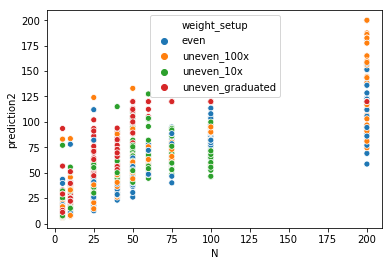

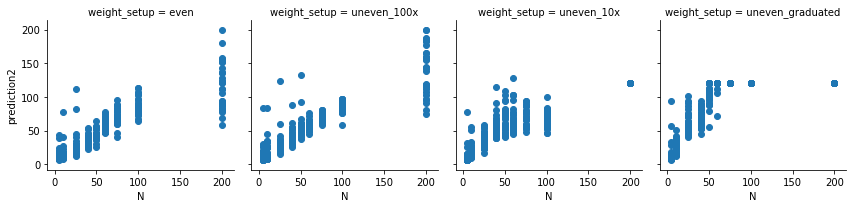

In [39]:
sns.scatterplot(x='N',y='prediction2',hue='weight_setup', data=test_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=test_matrix)
g.map(plt.scatter, 'N', 'prediction2')
plt.show()